In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import OrderedDict
import copy
import csv

## 读取数据

In [2]:
path = 'merge_target.csv'
merged_target = pd.read_csv(path)
merged_target

,warehouse_code,product_code,size_code,constrained_target_inv_qty,available_inv_qty,inventory_lower_limit,inventory_upper_limit
0,STOREM030,T5KCM29871,L,1,0,1.0,NaN
1,STOREM030,T5KCM29871,M,1,1,1.0,NaN
2,STOREM030,T5KCM29871,S,1,0,1.0,NaN
3,STOREM030,T5KCM29871,XL,1,0,1.0,NaN
4,STOREM032,T5KCM29871,L,1,1,1.0,NaN
...,...,...,...,...,...,...,...
339,STORE042,T5ABD07499,L,1,0,1.0,NaN
340,STORE042,T5ABD07499,S,1,0,1.0,NaN
341,WAREHOUSE020,T5ABD07499,L,0,0,NaN,NaN
342,WAREHOUSE020,T5KCM29871,M,0,0,NaN,NaN


In [3]:
path = 'skc_merge_strategy.csv'
skc_merge_strategy = pd.read_csv(path)
skc_merge_strategy

,product_code,store_upper_limit,out_store_clear_out
0,T5KCM29871,7,1
1,T5ABC12345,7,1
2,T5ABC33874,7,1
3,T5ABD07499,7,1


In [4]:
path = 'store_product.csv'
store_product = pd.read_csv(path)
store_product

,product_code,warehouse_code,in_store_priority
0,T5KCM29871,STOREM069,1
1,T5KCM29871,STOREM156,2
2,T5KCM29871,STORE008,3
3,T5KCM29871,STOREM030,4
4,T5KCM29871,STOREM161,5
...,...,...,...
102,T5ABC33874,STORE039,36
103,T5ABC33874,STORE041,37
104,T5ABC33874,STORE007,38
105,T5ABC33874,STORE023,39


In [5]:
path = 'weight.csv'
weight = pd.read_csv(path, encoding='utf-8')
weight

,target,weight
0,1,4
1,2,1
2,3,1
3,4,1


**计时器**

In [6]:
# 计时器
def calculate_execution_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"{func.__name__} 函数执行时间: {execution_time} 秒")
        return result
    return wrapper

## 决策变量

$x_{wsw'}$ 仓库 $w$ 中的 $s$ 向仓库 $w'$ 发送的数量

$x_{wsw'}$ 为本模型中的决策变量，其中 $w$ 代表单个仓库，$w\in W$。 $s$ 代表单个商品，即不同商品不同尺码的单品。$w'$代表仓库的集合中的另一个仓库，$w'\in W$。总来说，$x_{wsw'}$ 用于表示商品从仓库 $w$ 发送到另一个仓库 $w'$ 的数量。

In [7]:
# 提取三列 warehouse_code, product_code, size_code 并创建新列 target_warehouse

# 提取三列并创建新 DataFrame
SKU_transfer = merged_target[['warehouse_code', 'product_code','available_inv_qty','constrained_target_inv_qty', 'size_code'
                              ,'inventory_lower_limit','inventory_upper_limit']].copy()

# 添加新列 target_warehouse（你可以根据需要设置新列的值）
SKU_transfer['target_warehouse'] = 'null'
SKU_transfer['amount'] = 0

In [8]:
SKU_transfer

,warehouse_code,product_code,available_inv_qty,constrained_target_inv_qty,size_code,inventory_lower_limit,inventory_upper_limit,target_warehouse,amount
0,STOREM030,T5KCM29871,0,1,L,1.0,NaN,null,0
1,STOREM030,T5KCM29871,1,1,M,1.0,NaN,null,0
2,STOREM030,T5KCM29871,0,1,S,1.0,NaN,null,0
3,STOREM030,T5KCM29871,0,1,XL,1.0,NaN,null,0
4,STOREM032,T5KCM29871,1,1,L,1.0,NaN,null,0
...,...,...,...,...,...,...,...,...,...
339,STORE042,T5ABD07499,0,1,L,1.0,NaN,null,0
340,STORE042,T5ABD07499,0,1,S,1.0,NaN,null,0
341,WAREHOUSE020,T5ABD07499,0,0,L,NaN,NaN,null,0
342,WAREHOUSE020,T5KCM29871,0,0,M,NaN,NaN,null,0


### 生成一些重要的字典方便后续使用

决策变量 warehouse_code,product_code, size_code -> target_warehouse, product_code, size_code,amount

In [9]:
x_original = {(row['warehouse_code'], row['product_code'], row['size_code']): (row['target_warehouse'], row['product_code'], row['size_code'], row['amount']) for _, row in SKU_transfer.iterrows()}    

转入店上限   product_code -> store_upper_limit

In [10]:
product_code_to_store_upper_limit = skc_merge_strategy.set_index('product_code')['store_upper_limit'].to_dict()

归出店清空 product_code -> out_store_clear_out

In [11]:
product_code_to_out_store_clear_out = skc_merge_strategy.set_index('product_code')['out_store_clear_out'].to_dict()

商品尺码潜在目标仓库 product_code, size_code -> warehouses

In [12]:
# 获取所有的 product_code 和 size_code 组合
unique_combinations = SKU_transfer[['product_code', 'size_code']].drop_duplicates()

# 初始化一个空字典来存储结果
SKU_target_warehouses = {}

# 遍历所有的组合
for index, row in unique_combinations.iterrows():
    product_code = row['product_code']
    size_code = row['size_code']

    # 获取与该组合相关的 warehouse_code 列表
    related_warehouses = SKU_transfer[(SKU_transfer['product_code'] == product_code) & (SKU_transfer['size_code'] == size_code)]['warehouse_code'].tolist()

    # 添加组合和 warehouse_code 到字典中
    SKU_target_warehouses[(product_code, size_code)] = related_warehouses

原始库存 warehouse_code,product_code, size_code -> available_inv_qty

In [13]:
# 将 目前库存 数据框转换为字典以进行优化的查找
available_inv_qty_dict = {(row['warehouse_code'], row['product_code'],row['size_code']): row['available_inv_qty'] for _, row in SKU_transfer.iterrows()}

转入库存上下限 warehouse_code,product_code, size_code -> inventory_lower_limit,inventory_lower_limit

In [14]:
inventory_limit_dict = {(row['warehouse_code'], row['product_code'],row['size_code']): (row['inventory_lower_limit'],row['inventory_upper_limit']) for _, row in merged_target.iterrows()}

目标库存 warehouse_code,product_code, size_code -> constrained_target_inv_qty

In [15]:
constrained_target_dict = {(row['warehouse_code'], row['product_code'],row['size_code']): row['constrained_target_inv_qty'] for _, row in merged_target.iterrows()}

权重 weighted

In [16]:
weighted = weight.set_index('target')['weight'].to_dict()

仓库商品优先级 warehouse_code,product_code -> in_store_priority

In [17]:
# 分组并进行 Min-Max 缩放
store_product['in_store_priority'] = store_product.groupby('product_code')['in_store_priority'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)
# 将 priority 数据框转换为字典以进行优化的查找
priority_dict = {(row['warehouse_code'], row['product_code']): row['in_store_priority'] for _, row in store_product.iterrows()}

单个样本优先级 priority_dict_new   warehouse_code,product_code,size_code -> in_store_priority

In [18]:
# Initialize an empty dictionary for the new priority_dict_new
priority_dict_new = {}

# Loop through each key-value pair in SKU_target_warehouses
for (product_code, size_code), target_warehouses in SKU_target_warehouses.items():
    # Loop through the target warehouses
    for warehouse in target_warehouses:
        # Check if the (warehouse, product_code, size_code) key exists in priority_dict
        if (warehouse, product_code) in priority_dict:
            # Get the priority value from priority_dict
            priority = priority_dict[(warehouse, product_code)]
            # Create a new key in priority_dict_new
            key = (warehouse, product_code, size_code)
            priority_dict_new[key] = priority

SKU商品的潜在目标仓库

In [19]:
SKC_target_warehouses = {}

for key, value in SKU_target_warehouses.items():
    warehouse, size = key
    unique_values = list(OrderedDict.fromkeys(value))
    if warehouse not in SKC_target_warehouses.keys():
        SKC_target_warehouses[warehouse] = unique_values
    else:
        for v in unique_values:
            if v not in SKC_target_warehouses[warehouse]:
                SKC_target_warehouses[warehouse].append(v)

In [20]:
# 对字典中的值进行升序排序
for key, value in SKC_target_warehouses.items():
    SKC_target_warehouses[key] = sorted(value, key=lambda item: priority_dict.get((item, key), 0))

## 目标函数

$$min\ z = w_1f_1 + w_2f_2 + w_3f_3 + w_4f_4$$

### 目标函数1 ($f_1$)

$f_1$：优先归入到重要的店铺

$$f_1 = \sum_{w \in W}\sum_{s \in S}\left({Q'}_{ws}* L_{ws}\right)$$

这个子目标的目标是通过考虑每个仓库中分配后的商品数量和它们的优先级值，来优化分配方案。具体来说，它倾向于将商品分配给具有较高优先级值的仓库，以实现更好的分配结果。本文使用$Q’_{ws}$而不是$x_{wsw'}$，原因是当所有$x_{wsw'}$取0时，$f_1$取最小值0，这显然与建模的目的不相符。$Q'_{ws}$可以根据$x_{wsw'}$的值计算得出。

In [21]:
def transfer_SKU(input_x):
    x_temp = input_x.copy()
    available_inv_qty_dict_temp = available_inv_qty_dict.copy()
    # 将 需要转移的 数据框转换为字典以进行优化的查找
    transfer_warehouse_amount_dict = {key: value for key, value in x_temp.items() if value[0] not in (np.nan, "null")}

    
    # 初始化一个字典来存储每个目标仓库的库存变化
    inventory_changes = {}

    # 遍历 transfer_warehouse_amount_dict 中的每个条目
    for key, values in transfer_warehouse_amount_dict.items():
        source_warehouse, product_code, size_code = key
        target_warehouse, _, _, amount = values

        # 获取当前库存
        current_inventory = available_inv_qty_dict_temp.get(key, 0)

        # 计算运输出的库存变化
        inventory_change_out = -amount

        # 计算运输进的库存变化
        inventory_change_in = amount

        # 更新源仓库的库存变化
        source_key = (source_warehouse, product_code, size_code)
        if source_key in inventory_changes:
            inventory_changes[source_key] += inventory_change_out
        else:
            inventory_changes[source_key] = inventory_change_out

        # 更新目标仓库的库存变化
        target_key = (target_warehouse, product_code, size_code)
        if target_key in inventory_changes:
            inventory_changes[target_key] += inventory_change_in
        else:
            inventory_changes[target_key] = inventory_change_in

    # 更新当前库存
    for key, inventory_change in inventory_changes.items():
        warehouse_code, product_code, size_code = key
        current_inventory = available_inv_qty_dict_temp.get(key, 0)
        new_inventory = current_inventory + inventory_change
        available_inv_qty_dict_temp[key] = new_inventory
    
    return available_inv_qty_dict_temp

In [22]:
# @calculate_execution_time
def f1(x_input):
    x = x_input.copy()
    f1_value = 0
    x = transfer_SKU(x)
     # 遍历输入字典 x
    for key, value in x.items():
        source_warehouse, product_code, size_code = key
        amount = value

        # 获取 in_store_priority
        in_store_priority = priority_dict.get((source_warehouse, product_code), 0)

        # 计算 f1 值
        f1_value += amount * in_store_priority

    return f1_value

### 目标函数2 ($f_2$)


$f_2$：SKC归入店铺后水平尽量在店铺的铺货标准上下界内

$$f_2 = \sum_{w \in W}\sum_{s \in S}\left(\left/{Q'}_{ws}- L_{ws}\right/+\left/{Q'}_{ws}- U_{ws}\right/+\left/ U_{ws}-L_{ws}\right/\right)*H_{ws}$$

这个子目标的目标是通过比较分配后的商品数量和目标期望库存水平，来优化分配方案。它倾向于使分配后的库存水平尽量接近或达到目标期望水平，从而确保商品的分布与目标一致。此处使用所有SKC而不是仅仅是转移的SKC，并且将结果乘以优先级值，理由同子目标1，为了避开当所有$x_{wsw'}$取0时，$f_2$取最小值0。

In [23]:
# @calculate_execution_time
def f2(x):
    transfered = transfer_SKU(x)
    
    changed_warehouse_product_size = x.copy()
    
    f2_value = 0
    
    for key in changed_warehouse_product_size:
        current_qty_temp = transfered.get(key, 0)  # 使用get方法来获取值，如果键不存在，默认为0
        inventory_lower_limit, inventory_upper_limit = inventory_limit_dict.get(key, (0, 0))  # 同样使用get方法，设置默认值为(0, 0)
        priority = priority_dict[(key[0],key[1])]
        
        # 存在下界,不存在上界
        if not np.isnan(inventory_lower_limit) and np.isnan(inventory_upper_limit):
            if current_qty_temp < inventory_lower_limit:
                f2_value += (inventory_lower_limit - current_qty_temp) * priority
            
        # 存在上界,不存在下界    
        elif np.isnan(inventory_lower_limit) and not np.isnan(inventory_upper_limit):
            if current_qty_temp > inventory_upper_limit:
                f2_value += (current_qty_temp - inventory_upper_limit) * priority
        
        # 同时存在
        elif not np.isnan(inventory_upper_limit) and not np.isnan(inventory_lower_limit):
            f2_value += (abs(inventory_lower_limit - current_qty_temp) + abs(inventory_upper_limit - current_qty_temp) +(inventory_upper_limit - inventory_lower_limit))*priority
        
    return f2_value

### 目标函数3 ($f_3$)


$f_3$：SKU规划水平靠近店铺的期望

$$f_3 = \sum_{w \in W}\sum_{s \in S}\left/{Q'}_{ws}-T_{ws}\right/*H_{ws}$$

这个子目标的目标是通过比较分配后的商品数量和目标期望库存水平，来优化分配方案。它倾向于使分配后的库存水平尽量接近或达到目标期望水平，从而确保商品的分布与目标一致。$Q'_{ws}$可以根据所有的$x_{wsw'}$计算得出，因此通过调整$x_{wsw'}$这些决策变量，以最小化$f_3$的值，可以实现这个子目标的优化目标。

In [24]:
# @calculate_execution_time
def f3(x):
    f3_value = 0
    
    transfered = transfer_SKU(x)
    
    # 遍历 transfer 中的每一样本
    for key, value in transfered.items():
        expected_qty = constrained_target_dict.get(key, 0)
        priority = priority_dict[(key[0],key[1])]
        
        # 计算 f3 的部分值
        f3_value += abs(value - expected_qty) * priority
    
    return f3_value

### 目标函数4 ($f_4$)


在归入店均匀增加的同时，要优先分给优先级高的店铺

$$f_4= \sum_{w \in W}\sum_{s \in S} (H_{w,s}* \left|x_{wsw'} - avg(x_{wsw'}) \right|) $$

其中 $avg$ 为商品总调入量/调入店铺数

$$avg(x_{wsw'}) = \sum_{s \in S}\frac{x_{wsw'}}{\sum_{w \in W,w=w',x_{wsw'}>0}|1|} $$

In [25]:
def getAvg(x):
    # 首先，筛选掉 target_warehouse 列为空的行
    filtered_test = {key: [val for i, val in enumerate(transfer_dict[key]) if transfer_dict['target_warehouse'][i] != 'null'] for key in transfer_dict}

    # 根据 product_code 列进行分组，并对 target_warehouse 列进行去重计数
    unique_target_warehouse_counts = {key: [] for key in transfer_dict}
    for i, product_code in enumerate(transfer_dict['product_code']):
        if product_code in unique_target_warehouse_counts:
            if transfer_dict['target_warehouse'][i] not in unique_target_warehouse_counts[product_code]:
                unique_target_warehouse_counts[product_code].append(transfer_dict['target_warehouse'][i])

    # 根据 product_code 列进行分组，并计算送出的总 amount
    total_amount = {key: [] for key in transfer_dict}
    for i, product_code in enumerate(transfer_dict['product_code']):
        if product_code in total_amount:
            total_amount[product_code].append(transfer_dict['amount'][i])

    # 合并两个结果数据字典
    avg = {'product_code': [], 'amount': [], 'target_warehouse': [], 'avg_amount_per_target_warehouse': []}
    for product_code in unique_target_warehouse_counts:
        avg['product_code'].append(product_code)
        avg['amount'].append(sum(total_amount[product_code]))
        avg['target_warehouse'].append(len(unique_target_warehouse_counts[product_code]))
        avg['avg_amount_per_target_warehouse'].append(avg['amount'][-1] / avg['target_warehouse'][-1])

    return avg


In [26]:
# @calculate_execution_time
def f4(x_input):
    x = x_input.copy()
    transfer_warehouse_amount_dict = {key: value for key, value in x.items() if value[0] not in (np.nan, "null")}
    changed_warehouse_product_size = list(set([(value[0], value[1], value[2]) for _, value in x.items() if value[0] not in (np.nan, "null")]))

    avg_warehouse_product_size = {}  # 用于存储结果的字典

    # 初始化 avg_warehouse_product_size 字典
    for item in changed_warehouse_product_size:
        avg_warehouse_product_size[item] = {'count': 0, 'amount': 0}

    # 遍历 transfer_warehouse_amount_dict，更新 count 和 amount
    for value in transfer_warehouse_amount_dict.values():
        key = (value[0], value[1], value[2])  # 从 transfer_warehouse_amount_dict 获取对应的键
        if key in avg_warehouse_product_size:
            avg_warehouse_product_size[key]['count'] += 1
            avg_warehouse_product_size[key]['amount'] += value[3]

    # 计算平均值并更新 avg_warehouse_product_size 字典
    for key, values in avg_warehouse_product_size.items():
        values['avg'] = values['amount'] / values['count'] if values['count'] > 0 else 0
        
    f4_value = 0

    for key, value in transfer_warehouse_amount_dict.items():
        new_key = (value[0], value[1], value[2])  # 使用前三位作为新的键
        if new_key in avg_warehouse_product_size:
            avg = avg_warehouse_product_size[new_key]['avg']

            # 根据前两位从 priority_dict 获取 priority
            priority = priority_dict.get((value[0], value[1]), 0)

            amount = value[3]  # 获取 amount

            f4_value += priority * abs(amount - avg)
    
    return f4_value

**汇总Funciton**

发现一个问题，如果不进行任何操作的，f1 f2 f4全部为0，修改f3*优先级

In [27]:
def f(x_input):
    result = {}
    
    result['f1'] = weighted[1] * f1(x_input)
    
    result['f2'] = weighted[2] * f2(x_input)
    
    result['f3'] = weighted[3] * f3(x_input)
    
    result['f4'] = weighted[4] * f4(x_input)
    
    result['total'] = result['f1'] + result['f2'] + result['f3'] + result['f4']
    
    return result['total']

## 约束条件

**数量平衡**

分配前后的 SKU 总数量要一致。

$$\forall s \in S,\sum_{w \in W} Q_{ws} = \sum_{w \in W} Q'_{ws}$$

**此约束在函数 transfer_SKU(transfer) 中被满足**

**调出店需调空**

如果 SKC 要求归出店要调空（信息由 skc_merge_strategy.csv 中的 out_store_clear_out 给出），需要清空归出店库存。
	
$$\forall s \in S, \forall w \in W, \text{when} \ E_{ws} = 1, x_{wsw'} =\{0,Q_{ws}\}$$

In [28]:
def clearOut(product_code):
    if product_code_to_out_store_clear_out[product_code] == 1:
        return True
    return False

**调入店数目上限有要求**
	
信息由 skc_merge_strategy.csv 中的 store_upper_limit 给出。如果该数值为 0 表示，不用考虑该约束条件；如果该数值为 大于 0 的整数 n，那么要求特定 SKC（由 skc_merge_strategy.csv 中的product_code 给出），最多可以归入到 n 家店铺中。

$$\forall s \in S, \sum_{w \in W, w=w’,x_{wsw’}>0}|1| <= A_s$$


In [29]:
# @calculate_execution_time
def filter_and_generate_dict(target_warehouse):
    input_dict = target_warehouse.copy()
    filtered_dict = {}
    
    # 新增
    SKC_target_warehouses_temp = {}

    for key, value in target_warehouse.items():
        warehouse, size = key
        unique_values = list(OrderedDict.fromkeys(value))
        if warehouse not in SKC_target_warehouses_temp.keys():
            SKC_target_warehouses_temp[warehouse] = unique_values
        else:
            for v in unique_values:
                if v not in SKC_target_warehouses_temp[warehouse]:
                    SKC_target_warehouses_temp[warehouse].append(v)
    # 新增
    
    SKC_new_target_warehouses = {}                
    for k,v in SKC_target_warehouses_temp.items():
        num = product_code_to_store_upper_limit[k]
        if len(v) < num:
            selected_target_warehouses = v
        else:
            selected_target_warehouses = random.sample(v, num)
        SKC_new_target_warehouses[k] = selected_target_warehouses
    
    for key, target_warehouses in input_dict.items():
        product_code = key[0]
        size_code = key[1]
        
        target_warehouses = target_warehouse[(product_code,size_code)]
        current_available_warehouses = SKC_new_target_warehouses[product_code]
        
        res_warehouses = []
        for warehouse in target_warehouses:
            if warehouse in current_available_warehouses:
                res_warehouses.append(warehouse)
        
        # 创建新的字典键值对
        new_key = (product_code, size_code)
        filtered_dict[new_key] = res_warehouses
    
    return filtered_dict

**在单尺码上低优先级上的门店都归完了再归出高优先级的门店。**

$$\forall s \in S,\forall w_1,w_2,w' \in W,\text{when } H_{w_1s}<H_{w_2s} \text{ and } x_{w_2sw'}<Q_{w_2s},x_{w_1sw'}=0$$

In [30]:
# @calculate_execution_time
def applyPriorityConstraint(x_input):
    x = x_input.copy()
    new_transfer_warehouse_amount_dict = {}

    for key, value in x.items():
        current_warehouse, current_product, current_size = key
        priority = priority_dict.get((current_warehouse, current_product), 0)
        value = list(value)
        value.append(priority)
        new_transfer_warehouse_amount_dict[key] = tuple(value)

    x_priority = new_transfer_warehouse_amount_dict

    transfer_warehouse_amount_dict = {key: value for key, value in x.items() if value[0] not in (np.nan, "null")}

    for key, value in transfer_warehouse_amount_dict.items():
        current_warehouse, current_product, current_size = key
        target_warehouse, target_product, target_size, amount = value
        current_priority = priority_dict.get((current_warehouse, current_product), 0)

        higher_priority_warehouses = {keys: values for keys, values in sorted(priority_dict.items(), key=lambda x: x[1], reverse=True) if values > current_priority and keys[1] == current_product}
        for k, v in higher_priority_warehouses.items():
            available_higher_priority_warehouses = [(keys[0], keys[1], keys[2]) for keys in available_inv_qty_dict if (keys[0], keys[1], keys[2]) in available_inv_qty_dict and available_inv_qty_dict.get(keys, 0) - x.get(keys, (0, 0, 0, 0))[3] > 0 and k == (keys[0], keys[1]) and keys[2] == current_size]

            if len(available_higher_priority_warehouses) == 0:
                continue

            for available_warehouse in available_higher_priority_warehouses:
                available_qty = available_inv_qty_dict.get(available_warehouse) - x.get(available_warehouse, (0, 0, 0, 0))[3]

                if available_qty >= amount:
                    x[available_warehouse] = (target_warehouse, target_product, target_size, x.get(available_warehouse, (0, 0, 0, 0))[3] + amount)
                    if product_code_to_out_store_clear_out[available_warehouse[1]] == 1:
                        x[available_warehouse] = (target_warehouse, target_product, target_size, available_inv_qty_dict.get(available_warehouse))
                    amount = 0
                    break
                else:
                    x[available_warehouse] = (target_warehouse, target_product, target_size, x.get(available_warehouse, (0, 0, 0, 0))[3] + available_qty)
                    if product_code_to_out_store_clear_out[available_warehouse[1]] == 1:
                        x[available_warehouse] = (target_warehouse, target_product, target_size, available_inv_qty_dict.get(available_warehouse))
                    amount -= available_qty

                if amount <= 0:
                    break

        if amount <= 0:
            x[key] = ('null', target_product, target_size, 0)

    return x


## 粒子群算法

**只适用于连续变量，不适用于此。**

## 遗传算法（Genetic Algorithm, GA）

遗传算法是一种基于生物学进化理论的优化算法，用于寻找复杂问题的最佳解决方案。它模拟了自然界中的生物进化过程，通过逐代进化来搜索解决方案空间。

**基本概念和步骤**

遗传算法的核心思想是将问题的解表示为一组个体，每个个体都是一个潜在的解决方案。这些个体通过自然选择、交叉和变异来进化，从而产生更好的解决方案。

**基本步骤：**

1. 初始化种群：随机生成一组初始个体，作为第一代种群。

2. 评估适应度：为每个个体计算一个适应度分数，用于衡量其解决问题的能力。

3. 选择父代：根据适应度分数选择一部分个体作为父代，通常适应度较高的个体被选择更多次，模拟了自然选择过程。

4. 交叉操作：将选定的父代个体进行交叉操作，生成子代。这模拟了基因的遗传过程，其中个体的特征被组合以创建新的个体。

5. 变异操作：对一些子代个体进行变异操作，即随机改变其某些特征，以增加种群的多样性。

6. 构建新一代种群：将父代、子代和变异个体组合成新的种群。

7. 重复迭代：重复执行上述步骤，逐代进化种群，直到达到停止条件（例如，达到最大迭代次数或找到满意的解决方案）。

8. 输出最优解：算法结束后，返回具有最高适应度分数的个体，作为问题的最佳解决方案。

**初始化种群**

在遗传算法中，种群是解决问题的候选解的集合，它由一组个体（也称为染色体）组成。种群的初始生成是遗传算法优化过程的第一步，它通常采用随机生成的方法，创建一组初始解作为种群的成员。

本文首先获取当前商品的可用库存数量。如果库存为空（等于零），那么将跳过这个基因，因为没有可用的商品。如果库存不为空，这时需要确定将商品调拨到哪个目标仓库以及调拨的数量。这个决策将基于两个因素：优先级和随机性。如果该商品在该商店中的优先级值较高，那么大概率会将该商品调出（降低约束4的运行时间）。之后，对于将要调出的商品，考虑目标仓库和调拨的数量。对于目标仓库，本文根据其最大分配店铺数，随机选取满足约束的店铺进行分配；对于调拨数量，考虑其是否需调空，调整调出商品的数量。最后，转换该染色体，使其满足约束条件4，确保在归入店铺时均匀增加库存，但仍然优先分给高优先级的店铺。这样，就生成了一个完整的染色体，它代表了一个潜在的解决方案。

In [31]:
def generate_initial_population(population_size):
    
    population = []
    for _ in range(population_size):
        chromosome = copy.deepcopy(x_original)
        
        # 获取过滤后的潜在目标warehouse，约束3
        filtered_warehouse_dict = filter_and_generate_dict(SKU_target_warehouses)
        
        for key,value in chromosome.items():
            current_warehouse, product_code, size_code = key
            target_warehouse, _, _, amount = value
            available_qty = available_inv_qty_dict[key]
            target_warehouses_list = filtered_warehouse_dict[(product_code, size_code)]
            priority = priority_dict[(current_warehouse, product_code)]
            
            if available_qty == 0:
                continue
            else:
                if random.random() < priority or len(target_warehouses_list) == 0:
                    target_warehouse == 'null'
                    continue
                target_warehouse = random.choice(target_warehouses_list)
                i = 0
                while target_warehouse == current_warehouse:
                    target_warehouse = random.choice(target_warehouses_list)
                    i+=1
                    if i == 10:
                        target_warehouse = 'null'
                        break
                # 约束2
                if clearOut(product_code):
                    amount = available_qty
                else:
                    amount = random.randint(1, available_qty)
                        
            chromosome[key] = target_warehouse, product_code, size_code,amount
        
        # 约束4
        chromosome = applyPriorityConstraint(chromosome)
        
        population.append(chromosome)

    return population

**评估**

在遗传算法中，一旦我们生成了种群中的个体（染色体），接下来的步骤是评估每个个体的适应度。适应度是一个数值，它度量了某个个体在问题的解空间中的表现好坏，即它有多好地满足了问题的目标和约束条件。

In [32]:
# 评估适应度函数（根据问题定义适应度函数）
def evaluate_fitness(chromosome):
    return f(chromosome)

**选择**

选择是遗传算法中的一个重要步骤，用于确定哪些个体将成为下一代的父代。选择过程通常依赖于个体的适应度，即个体满足问题目标和约束的程度。

本文通过锦标赛选择方法，适应度值较小的个体更有可能被选中作为下一代的父代，以促进算法朝着更优解的方向演化。遗传算法中的选择操作起到筛选、筛除不适应的个体的作用，帮助种群向更好的解前进。

In [33]:
def select_parents(population, fitness_values, num_parents):
    parents = []

    tournament_size = 2
    for _ in range(num_parents):
        # 随机选择一组个体进行锦标赛
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [fitness_values[i] for i in tournament_indices]

        # 选择锦标赛中适应度最小的个体
        winner_index = tournament_indices[tournament_fitness.index(min(tournament_fitness))]

        parents.append(population[winner_index])

    return parents

**交叉**

在遗传算法中，交叉是繁殖下一代个体的关键步骤。它模拟了生物遗传中的杂交过程，即通过随机选择一对父代，将它们的特征进行交叉，从而生成新的后代个体。

本文首先根据两个父染色体选择出子节点可用的目标仓库，之后根据父节点基因去确定子节点的基因。最后再进行运算，使其满足约束4。

In [34]:
def getTargetWarehouses(x):
    unique_values = {}
    for key, value in x.items():
        key1, key2 = key[1], key[2]
        if (key1, key2) in unique_values:
            unique_values[(key1, key2)].add(value[0])
        else:
            unique_values[(key1, key2)] = {value[0]}

    # 将集合转换为列表
    unique_values_list = {key: list(values) for key, values in unique_values.items()}
    
    return unique_values_list

In [35]:
# 交叉函数
def crossover(parents, num_offsprings):
    offsprings = []
    for _ in range(num_offsprings):
        p1, p2 = random.sample(parents, 2)
        
        chromosome = copy.deepcopy(x_original)  # 初始化子代个体为字典
        
        p1_target_warehouse = getTargetWarehouses(p1)
        p2_target_warehouse = getTargetWarehouses(p2)
        
        # 初始化一个新字典来存储合并后的结果
        merged_target_warehouse = {}

        # 遍历dic1和dic2中的所有键
        for key in p1_target_warehouse.keys():
            # 获取dic1和dic2中对应键的值（列表）
            list1 = p1_target_warehouse[key]
            list2 = p2_target_warehouse[key]

            # 从这些值中去除'null'，使用列表推导式
            cleaned_list1 = [item for item in list1 if item != 'null']
            cleaned_list2 = [item for item in list2 if item != 'null']

            # 获取这两个列表的并集
            merged_list = list(set(cleaned_list1).union(cleaned_list2))

            # 将合并后的结果存储在新字典中
            merged_target_warehouse[key] = merged_list
        
        available_merged_target_warehouse = filter_and_generate_dict(merged_target_warehouse)
        
        base_p = p1
        if evaluate_fitness(p1) > evaluate_fitness(p2):
            base_p = p2
        
        for key,value in chromosome.items():
            current_warehouse, product_code, size_code = key
            target_warehouse, _, _, amount = value
            available_qty = available_inv_qty_dict[key]
            target_warehouses_list = available_merged_target_warehouse[(product_code, size_code)]
            priority = priority_dict[(current_warehouse, product_code)]
            target_warehouse_p1 = p1[key][0]
            amount_p1 = p1[key][3]
            target_warehouse_p2 = p2[key][0]
            amount_p2 = p2[key][3]
            target_warehouse_base_p = base_p[key][0]
            amount_base_p = base_p[key][3]
            
            # 如果都为空那么不进行任何操作，继续循环
            if target_warehouse_p1 == 'null' or target_warehouse_p2 == 'null':
                continue
            
            elif target_warehouse_p1 != 'null' and target_warehouse_p2 == 'null':
                if target_warehouse_p1 in target_warehouses_list and target_warehouse_p1 != current_warehouse:
                    target_warehouse = target_warehouse_p1
                    amount = amount_p1
                else:
                    target_warehouse = 'null'
                    amount = 0
                
            elif target_warehouse_p1 == 'null' and target_warehouse_p2 != 'null':
                if target_warehouse_p2 in target_warehouses_list and target_warehouse_p2 != current_warehouse:
                    target_warehouse = target_warehouse_p2
                    amount = amount_p2
                else:
                    target_warehouse = 'null'
                    amount = 0
                
            elif target_warehouse_p1 != 'null' and target_warehouse_p2 != 'null':
                if target_warehouse_base_p in target_warehouses_list and target_warehouse_base_p != current_warehouse:
                    target_warehouse = target_warehouse_base_p
                    amount = amount_base_p
                else:
                    target_warehouse = 'null'
                    amount = 0
                    
                        
            chromosome[key] = target_warehouse, product_code, size_code,amount
        
        # 约束4
        chromosome = applyPriorityConstraint(chromosome)
        
        offsprings.append(chromosome)

    return offsprings  

**变异**

在遗传算法中，变异是引入随机性以增加多样性的过程。变异通过对一些后代进行修改，可以帮助算法逃离局部最优解，进一步探索搜索空间。

对于单个染色体，设置其变异概率。如果变异，那么更新其目标仓库，在满足约束条件的情况下，添加新的优先级值低的目标仓库。之后根据目标仓库去更新变异染色体。

In [36]:
# 变异函数,对于SKU的目标仓库 突变到 优先级更高的目标仓库
def mutate(x, mutation_rate):
    mutated_x = copy.deepcopy(x)
    
    total_mutation_rate = mutation_rate
    if random.random() > total_mutation_rate:
        return mutated_x
    gene_mutation_rate = 0.1
    
    x_target_warehouses = getTargetWarehouses(mutated_x)
    
    merged_target_warehouses = {}

    for key, value in x_target_warehouses.items():
        warehouse, size = key
        unique_values = list(OrderedDict.fromkeys(value))
        if warehouse not in merged_target_warehouses.keys():
            merged_target_warehouses[warehouse] = unique_values
        else:
            for v in unique_values:
                if v not in merged_target_warehouses[warehouse]:
                    merged_target_warehouses[warehouse].append(v)
    
    for product,warehouse_list in merged_target_warehouses.items():
        warehouse_list = [item for item in warehouse_list if item != 'null']
        index = 0
        for warehouse in warehouse_list:
            if random.random() < gene_mutation_rate:
                temp_warehouse = random.choice(SKC_target_warehouses[product])
                count = 0
                while temp_warehouse not in warehouse_list and priority_dict[(temp_warehouse,product)] < priority_dict[(warehouse,product)] and temp_warehouse != 'null':
                    temp_warehouse = random.choice(SKC_target_warehouses[product])
                    count+=1
                    if count == 10:
                        break
                if count < 10:
                    merged_target_warehouses[product][index] = temp_warehouse
            index+=1

        if len(warehouse_list) < product_code_to_store_upper_limit[product]:
            new_added_warehouse_amount = product_code_to_store_upper_limit[product]-len(warehouse_list)
            for i in range(new_added_warehouse_amount):
                if random.random() < gene_mutation_rate:
                    temp_warehouse = random.choice(SKC_target_warehouses[product])
                    f = 0
                    while temp_warehouse not in warehouse_list and temp_warehouse != 'null':
                        temp_warehouse = random.choice(SKC_target_warehouses[product])
                        f+=1
                        if f == 10:
                            break
                    merged_target_warehouses[product].append(temp_warehouse)
    
    filtered_dict={}
    for key, target_warehouses in SKU_target_warehouses.items():
        product_code = key[0]
        size_code = key[1]

        target_warehouses = SKU_target_warehouses[(product_code,size_code)]
        current_available_warehouses = merged_target_warehouses[product_code]

        res_warehouses = []
        for warehouse in target_warehouses:
            if warehouse in current_available_warehouses:
                res_warehouses.append(warehouse)

        # 创建新的字典键值对
        new_key = (product_code, size_code)
        filtered_dict[new_key] = res_warehouses
    
    for key,value in mutated_x.items():
        current_warehouse, product_code, size_code = key
        target_warehouse, _, _, amount = value
        available_qty = available_inv_qty_dict[key]
        target_warehouses_list = filtered_dict[(product_code, size_code)]
        priority = priority_dict[(current_warehouse, product_code)]

        if available_qty == 0 and target_warehouse != 'null':
            continue
        else:
            if random.random() < priority or len(target_warehouses_list) == 0:
                target_warehouse = 'null'
                continue

            target_warehouse = random.choice(target_warehouses_list)
            i=0
            while target_warehouse == current_warehouse:
                target_warehouse = random.choice(target_warehouses_list)
                i+=1
                if i == 10:
                    target_warehouse = 'null'
                    break
            # 约束2
            if clearOut(product_code):
                amount = available_qty
            else:
                amount = random.randint(1, available_qty)

        mutated_x[key] = target_warehouse, product_code, size_code,amount  
    return mutated_x

In [37]:
@calculate_execution_time
def genetic_algorithm(population_size, num_generations, mutation_rate, max_iterations):
    population = generate_initial_population(population_size)
    best_fitness_history = []  # 存储每代中的最佳适应度分数
    res_best_solution = population[0]  # 初始化最优解
    res_best_fitness = evaluate_fitness(res_best_solution)

    break_flag = 0  # 用于记录连续未改善的代数
    for generation in range(num_generations):
        print(f"Generation {generation + 1}:")
        # 评估种群中每个个体的适应度
        fitness_scores = []

        for chromosome in population:
            v = evaluate_fitness(chromosome)
            fitness_scores.append(v)

        # 记录每代中的最佳适应度分数
        best_fitness = min(fitness_scores)
        best_fitness_history.append(best_fitness)
        print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

        if best_fitness < res_best_fitness:
            break_flag = 0
            res_best_fitness = best_fitness
            res_best_solution = population[fitness_scores.index(best_fitness)]
        elif best_fitness == res_best_fitness:
            break_flag += 1
            if break_flag >= max_iterations:
                print(f"Terminating early after {break_flag} generations without improvement.")
                break
        else:
            break_flag += 1
            if break_flag >= max_iterations:
                print(f"Terminating early after {break_flag} generations without improvement.")
                break

        # 选择父代
        num_parents = population_size // 2
        parents = select_parents(population, fitness_scores, num_parents)

        # 交叉操作
        num_offsprings = population_size - num_parents
        offsprings = crossover(parents, num_offsprings)

        # 变异操作
        mutated_offsprings = [mutate(chromosome, mutation_rate) for chromosome in offsprings]

        # 构建新一代种群
        population = parents + mutated_offsprings

    # 返回最优解
    best_chromosome = res_best_solution
    best_chromosome_fitness = res_best_fitness

    # 画出最优解与迭代次数的折线图
    plt.plot(range(1, len(best_fitness_history) + 1), best_fitness_history)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.title('Best Fitness vs. Generation')
    plt.show()

    return best_chromosome, best_chromosome_fitness

Generation 1:
Generation 1: Best Fitness = 418.4973009446695
Generation 2:
Generation 2: Best Fitness = 396.5241951031424
Generation 3:
Generation 3: Best Fitness = 385.50418353576254
Generation 4:
Generation 4: Best Fitness = 366.3292847503374
Generation 5:
Generation 5: Best Fitness = 362.48110661268555
Generation 6:
Generation 6: Best Fitness = 358.9834682860999
Generation 7:
Generation 7: Best Fitness = 358.9834682860999
Generation 8:
Generation 8: Best Fitness = 358.9834682860999
Generation 9:
Generation 9: Best Fitness = 362.48110661268555
Generation 10:
Generation 10: Best Fitness = 364.57557354925774
Generation 11:
Generation 11: Best Fitness = 364.57557354925774
Generation 12:
Generation 12: Best Fitness = 364.57557354925774
Generation 13:
Generation 13: Best Fitness = 364.57557354925774
Generation 14:
Generation 14: Best Fitness = 364.57557354925774
Generation 15:
Generation 15: Best Fitness = 364.57557354925774
Generation 16:
Generation 16: Best Fitness = 364.89136302294196


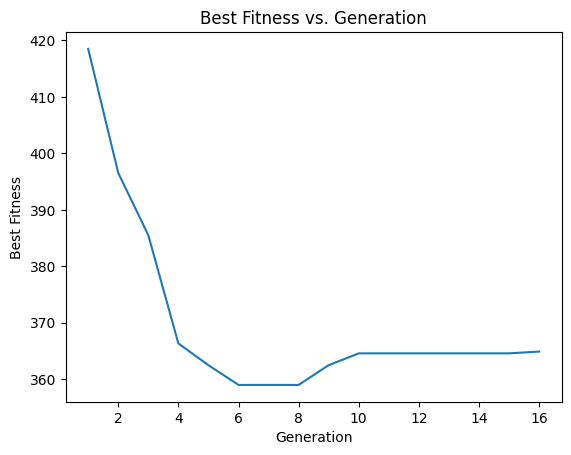

genetic_algorithm 函数执行时间: 255.75475597381592 秒
Best Fitness: 358.9834682860999
Best Solution:


{('STOREM030', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM030', 'T5KCM29871', 'M'): ('null', 'T5KCM29871', 'M', 0),
 ('STOREM030', 'T5KCM29871', 'S'): ('null', 'T5KCM29871', 'S', 0),
 ('STOREM030', 'T5KCM29871', 'XL'): ('null', 'T5KCM29871', 'XL', 0),
 ('STOREM032', 'T5KCM29871', 'L'): ('STOREM194', 'T5KCM29871', 'L', 1),
 ('STOREM069', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM069', 'T5KCM29871', 'M'): ('null', 'T5KCM29871', 'M', 0),
 ('STOREM069', 'T5KCM29871', 'S'): ('null', 'T5KCM29871', 'S', 0),
 ('STOREM069', 'T5KCM29871', 'XL'): ('null', 'T5KCM29871', 'XL', 0),
 ('STOREM156', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM156', 'T5KCM29871', 'M'): ('null', 'T5KCM29871', 'M', 0),
 ('STOREM156', 'T5KCM29871', 'XL'): ('null', 'T5KCM29871', 'XL', 0),
 ('STOREM156', 'T5KCM29871', 'XXL'): ('null', 'T5KCM29871', 'XXL', 0),
 ('STOREM161', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM161', 'T5KCM29871', 'M'): ('null', 'T5

In [38]:
# 使用 max_iterations 参数设置连续未改善的最大代数
best_solution, best_fitness = genetic_algorithm(population_size=200, num_generations=50, mutation_rate=0.2, max_iterations=10)
print(f'Best Fitness: {best_fitness}')
print("Best Solution:")
best_solution

In [39]:
res_best_solution = transfer_SKU(best_solution)

In [40]:
# 指定要保存到的 CSV 文件名
csv_filename = 'result_200.csv'

# 将字典转换为行列表
rows = [(key[0], key[1], key[2], value) for key, value in res_best_solution.items()]

# 写入 CSV 文件
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # 写入 CSV 文件的表头
    csv_writer.writerow(['warehouse_code', 'product_code', 'size_code', 'allocation_inv_qty'])
    
    # 写入数据行
    csv_writer.writerows(rows)

print(f'Data has been saved to {csv_filename}')

Data has been saved to result_200.csv


Generation 1:
Generation 1: Best Fitness = 439.0591864276076
Generation 2:
Generation 2: Best Fitness = 401.4587269455691
Generation 3:
Generation 3: Best Fitness = 383.56983805668017
Generation 4:
Generation 4: Best Fitness = 383.56983805668017
Generation 5:
Generation 5: Best Fitness = 368.82159244264517
Generation 6:
Generation 6: Best Fitness = 374.6097165991903
Generation 7:
Generation 7: Best Fitness = 372.1220358588779
Generation 8:
Generation 8: Best Fitness = 372.1220358588779
Generation 9:
Generation 9: Best Fitness = 372.1220358588779
Generation 10:
Generation 10: Best Fitness = 372.1220358588779
Generation 11:
Generation 11: Best Fitness = 370.9641411220358
Generation 12:
Generation 12: Best Fitness = 370.9641411220358
Generation 13:
Generation 13: Best Fitness = 370.9641411220358
Generation 14:
Generation 14: Best Fitness = 370.9641411220358
Generation 15:
Generation 15: Best Fitness = 370.9641411220358
Terminating early after 10 generations without improvement.


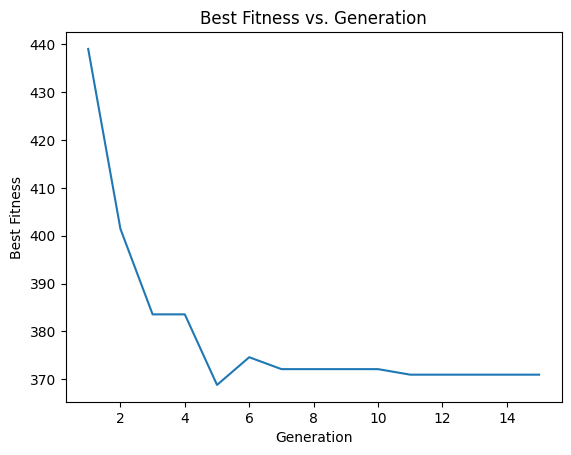

genetic_algorithm 函数执行时间: 133.14091992378235 秒
Best Fitness: 368.82159244264517
Best Solution:


{('STOREM030', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM030', 'T5KCM29871', 'M'): ('WAREHOUSE020', 'T5KCM29871', 'M', 1),
 ('STOREM030', 'T5KCM29871', 'S'): ('null', 'T5KCM29871', 'S', 0),
 ('STOREM030', 'T5KCM29871', 'XL'): ('null', 'T5KCM29871', 'XL', 0),
 ('STOREM032', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM069', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM069', 'T5KCM29871', 'M'): ('null', 'T5KCM29871', 'M', 0),
 ('STOREM069', 'T5KCM29871', 'S'): ('null', 'T5KCM29871', 'S', 0),
 ('STOREM069', 'T5KCM29871', 'XL'): ('null', 'T5KCM29871', 'XL', 0),
 ('STOREM156', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM156', 'T5KCM29871', 'M'): ('null', 'T5KCM29871', 'M', 0),
 ('STOREM156', 'T5KCM29871', 'XL'): ('STOREM069', 'T5KCM29871', 'XL', 1),
 ('STOREM156', 'T5KCM29871', 'XXL'): ('null', 'T5KCM29871', 'XXL', 0),
 ('STOREM161', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM161', 'T5KCM29871', 'M'): ('ST

In [41]:
# 使用 max_iterations 参数设置连续未改善的最大代数
best_solution, best_fitness = genetic_algorithm(population_size=100, num_generations=50, mutation_rate=0.2, max_iterations=10)
print(f'Best Fitness: {best_fitness}')
print("Best Solution:")
best_solution

In [42]:
res_best_solution = transfer_SKU(best_solution)

In [43]:
# 指定要保存到的 CSV 文件名
csv_filename = 'result_100.csv'

# 将字典转换为行列表
rows = [(key[0], key[1], key[2], value) for key, value in res_best_solution.items()]

# 写入 CSV 文件
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # 写入 CSV 文件的表头
    csv_writer.writerow(['warehouse_code', 'product_code', 'size_code', 'allocation_inv_qty'])
    
    # 写入数据行
    csv_writer.writerows(rows)

print(f'Data has been saved to {csv_filename}')

Data has been saved to result_100.csv


Generation 1:
Generation 1: Best Fitness = 463.7475708502024
Generation 2:
Generation 2: Best Fitness = 401.20791752107533
Generation 3:
Generation 3: Best Fitness = 372.59090032774236
Generation 4:
Generation 4: Best Fitness = 382.5385228806281
Generation 5:
Generation 5: Best Fitness = 377.8689030267977
Generation 6:
Generation 6: Best Fitness = 369.8029689608636
Generation 7:
Generation 7: Best Fitness = 368.26450742240206
Generation 8:
Generation 8: Best Fitness = 368.26450742240206
Generation 9:
Generation 9: Best Fitness = 368.26450742240206
Generation 10:
Generation 10: Best Fitness = 368.26450742240206
Generation 11:
Generation 11: Best Fitness = 368.26450742240206
Generation 12:
Generation 12: Best Fitness = 368.26450742240206
Generation 13:
Generation 13: Best Fitness = 369.1012145748987
Generation 14:
Generation 14: Best Fitness = 369.1012145748987
Generation 15:
Generation 15: Best Fitness = 369.1012145748987
Generation 16:
Generation 16: Best Fitness = 369.1012145748987
Ge

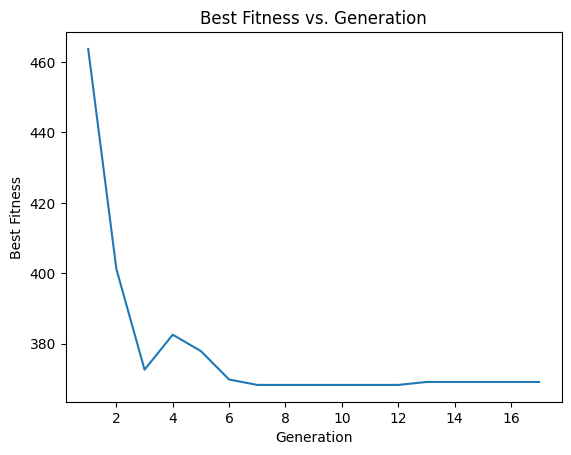

genetic_algorithm 函数执行时间: 78.91347169876099 秒
Best Fitness: 368.26450742240206
Best Solution:


{('STOREM030', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM030', 'T5KCM29871', 'M'): ('STOREM197', 'T5KCM29871', 'M', 1),
 ('STOREM030', 'T5KCM29871', 'S'): ('null', 'T5KCM29871', 'S', 0),
 ('STOREM030', 'T5KCM29871', 'XL'): ('null', 'T5KCM29871', 'XL', 0),
 ('STOREM032', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM069', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM069', 'T5KCM29871', 'M'): ('null', 'T5KCM29871', 'M', 0),
 ('STOREM069', 'T5KCM29871', 'S'): ('null', 'T5KCM29871', 'S', 0),
 ('STOREM069', 'T5KCM29871', 'XL'): ('null', 'T5KCM29871', 'XL', 0),
 ('STOREM156', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM156', 'T5KCM29871', 'M'): ('null', 'T5KCM29871', 'M', 0),
 ('STOREM156', 'T5KCM29871', 'XL'): ('STOREM197', 'T5KCM29871', 'XL', 1),
 ('STOREM156', 'T5KCM29871', 'XXL'): ('null', 'T5KCM29871', 'XXL', 0),
 ('STOREM161', 'T5KCM29871', 'L'): ('null', 'T5KCM29871', 'L', 0),
 ('STOREM161', 'T5KCM29871', 'M'): ('STORE

In [44]:
# 使用 max_iterations 参数设置连续未改善的最大代数
best_solution, best_fitness = genetic_algorithm(population_size=50, num_generations=50, mutation_rate=0.2, max_iterations=10)
print(f'Best Fitness: {best_fitness}')
print("Best Solution:")
best_solution

In [45]:
res_best_solution = transfer_SKU(best_solution)

# 指定要保存到的 CSV 文件名
csv_filename = 'result_50.csv'

# 将字典转换为行列表
rows = [(key[0], key[1], key[2], value) for key, value in res_best_solution.items()]

# 写入 CSV 文件
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # 写入 CSV 文件的表头
    csv_writer.writerow(['warehouse_code', 'product_code', 'size_code', 'allocation_inv_qty'])
    
    # 写入数据行
    csv_writer.writerows(rows)

print(f'Data has been saved to {csv_filename}')

Data has been saved to result_50.csv


Generation 1:
Generation 1: Best Fitness = 432.2712550607289
Generation 2:
Generation 2: Best Fitness = 406.57602339181284
Generation 3:
Generation 3: Best Fitness = 378.00809716599184
Generation 4:
Generation 4: Best Fitness = 378.00809716599184
Generation 5:
Generation 5: Best Fitness = 376.3033738191633
Generation 6:
Generation 6: Best Fitness = 373.48286099865044
Generation 7:
Generation 7: Best Fitness = 373.4719666298613
Generation 8:
Generation 8: Best Fitness = 371.7196049564471
Generation 9:
Generation 9: Best Fitness = 371.7196049564471
Generation 10:
Generation 10: Best Fitness = 371.7196049564471
Generation 11:
Generation 11: Best Fitness = 371.7196049564471
Generation 12:
Generation 12: Best Fitness = 374.8140718930192
Generation 13:
Generation 13: Best Fitness = 374.8140718930192
Generation 14:
Generation 14: Best Fitness = 374.8140718930192
Generation 15:
Generation 15: Best Fitness = 374.8140718930192
Generation 16:
Generation 16: Best Fitness = 374.8140718930192
Genera

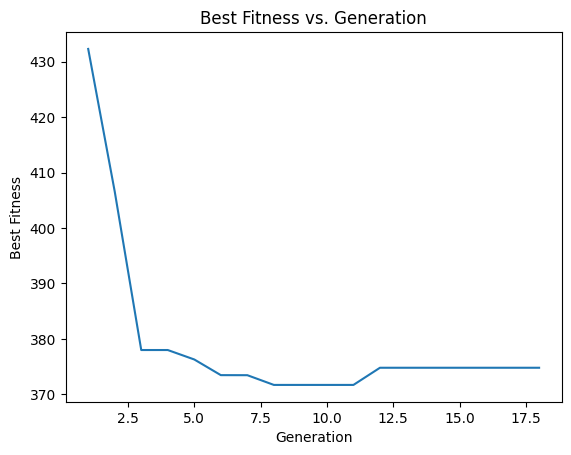

genetic_algorithm 函数执行时间: 145.5837914943695 秒
Best Fitness: 371.7196049564471
Best Solution:
Data has been saved to result_100_10.csv


In [46]:
# 使用 max_iterations 参数设置连续未改善的最大代数
best_solution, best_fitness = genetic_algorithm(population_size=100, num_generations=100, mutation_rate=0.1, max_iterations=10)
print(f'Best Fitness: {best_fitness}')
print("Best Solution:")
best_solution
# 指定要保存到的 CSV 文件名
csv_filename = 'result_100_10.csv'
res_best_solution = transfer_SKU(best_solution)
# 将字典转换为行列表
rows = [(key[0], key[1], key[2], value) for key, value in res_best_solution.items()]

# 写入 CSV 文件
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # 写入 CSV 文件的表头
    csv_writer.writerow(['warehouse_code', 'product_code', 'size_code', 'allocation_inv_qty'])
    
    # 写入数据行
    csv_writer.writerows(rows)

print(f'Data has been saved to {csv_filename}')

Generation 1:
Generation 1: Best Fitness = 436.3825604220342
Generation 2:
Generation 2: Best Fitness = 391.8943687891057
Generation 3:
Generation 3: Best Fitness = 370.78896761133615
Generation 4:
Generation 4: Best Fitness = 379.2310391363023
Generation 5:
Generation 5: Best Fitness = 362.5226045883941
Generation 6:
Generation 6: Best Fitness = 363.9095816464238
Generation 7:
Generation 7: Best Fitness = 363.9095816464238
Generation 8:
Generation 8: Best Fitness = 363.9095816464238
Generation 9:
Generation 9: Best Fitness = 363.9095816464238
Generation 10:
Generation 10: Best Fitness = 363.9095816464238
Generation 11:
Generation 11: Best Fitness = 363.9095816464238
Generation 12:
Generation 12: Best Fitness = 363.9095816464238
Generation 13:
Generation 13: Best Fitness = 363.9095816464238
Generation 14:
Generation 14: Best Fitness = 363.9095816464238
Generation 15:
Generation 15: Best Fitness = 363.9095816464238
Terminating early after 10 generations without improvement.


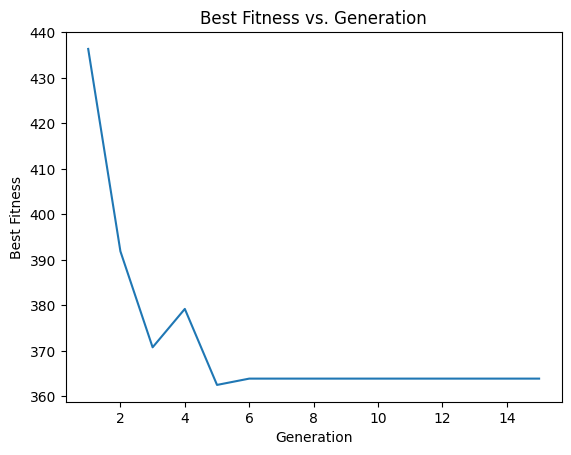

genetic_algorithm 函数执行时间: 253.94944882392883 秒
Best Fitness: 362.5226045883941
Best Solution:
Data has been saved to result_200_10.csv


In [47]:
# 使用 max_iterations 参数设置连续未改善的最大代数
best_solution, best_fitness = genetic_algorithm(population_size=200, num_generations=50, mutation_rate=0.1, max_iterations=10)
print(f'Best Fitness: {best_fitness}')
print("Best Solution:")
best_solution

res_best_solution = transfer_SKU(best_solution)

# 指定要保存到的 CSV 文件名
csv_filename = 'result_200_10.csv'

# 将字典转换为行列表
rows = [(key[0], key[1], key[2], value) for key, value in res_best_solution.items()]

# 写入 CSV 文件
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # 写入 CSV 文件的表头
    csv_writer.writerow(['warehouse_code', 'product_code', 'size_code', 'allocation_inv_qty'])
    
    # 写入数据行
    csv_writer.writerows(rows)

print(f'Data has been saved to {csv_filename}')

Generation 1:
Generation 1: Best Fitness = 440.65784653942546
Generation 2:
Generation 2: Best Fitness = 419.70292397660813
Generation 3:
Generation 3: Best Fitness = 404.88353576248323
Generation 4:
Generation 4: Best Fitness = 391.6612685560054
Generation 5:
Generation 5: Best Fitness = 385.65182186234813
Generation 6:
Generation 6: Best Fitness = 384.41565452091766
Generation 7:
Generation 7: Best Fitness = 383.04858299595145
Generation 8:
Generation 8: Best Fitness = 380.3819163292847
Generation 9:
Generation 9: Best Fitness = 380.31493068335175
Generation 10:
Generation 10: Best Fitness = 380.0841614525825
Generation 11:
Generation 11: Best Fitness = 380.0369279842964
Generation 12:
Generation 12: Best Fitness = 380.26769721506565
Generation 13:
Generation 13: Best Fitness = 380.26769721506565
Generation 14:
Generation 14: Best Fitness = 380.26769721506565
Generation 15:
Generation 15: Best Fitness = 380.26769721506565
Generation 16:
Generation 16: Best Fitness = 380.2676972150656

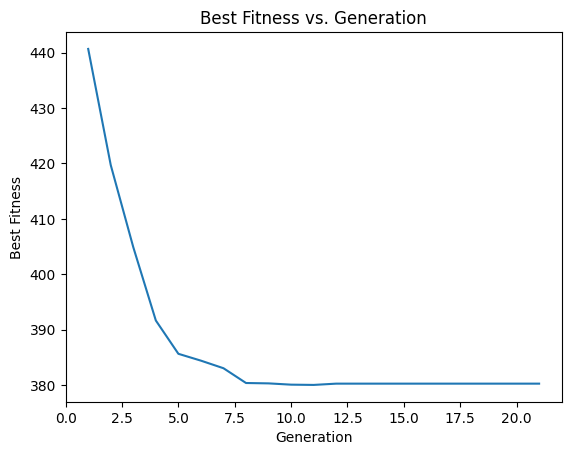

genetic_algorithm 函数执行时间: 84.44827580451965 秒
Best Fitness: 380.0369279842964
Best Solution:
Data has been saved to result_50_10.csv


In [48]:
# 使用 max_iterations 参数设置连续未改善的最大代数
best_solution, best_fitness = genetic_algorithm(population_size=50, num_generations=200, mutation_rate=0.1, max_iterations=10)
print(f'Best Fitness: {best_fitness}')
print("Best Solution:")
best_solution

res_best_solution = transfer_SKU(best_solution)

# 指定要保存到的 CSV 文件名
csv_filename = 'result_50_10.csv'

# 将字典转换为行列表
rows = [(key[0], key[1], key[2], value) for key, value in res_best_solution.items()]

# 写入 CSV 文件
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # 写入 CSV 文件的表头
    csv_writer.writerow(['warehouse_code', 'product_code', 'size_code', 'allocation_inv_qty'])
    
    # 写入数据行
    csv_writer.writerows(rows)

print(f'Data has been saved to {csv_filename}')